#Face detector
Store the face images to drive

In [ ]:
!pip install facenet-pytorch

from facenet_pytorch import MTCNN, extract_face
import matplotlib.image as mpl
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import glob

mtcnn = MTCNN()

     |████████████████████████████████| 1.9MB 7.7MB/s 


In [ ]:
#Set the paths
path = '/content/drive/MyDrive/UAM/PDBR/Task_1/evaluation/real/*/'
face_path = '/content/drive/MyDrive/UAM/PDBR/Task_1/evaluation_face/real/'



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Counter
it=0
for img in glob.glob(path+"*.jpg"):
    it=it+1
    

    im=mpl.imread(img)

    #image height
    h= int(im.shape[0])
    #image width
    w= int(im.shape[1]) 

    #name of the new files
    #OR real.jpg
    file_name=face_path+str (it)+'fake.jpg'


    try:
        boxes, probs = mtcnn.detect(im)
    except RuntimeError as e:
        print(f"Failed to detected image {im_path}")
        continue
    #Detection

    

    #if there is no detection, save the original image
    if boxes is None:
    #  mpl.imsave(file_name, im)
      print("there is one image, where there is no detection..")
      continue;


    #We will consider just one detection with the biggest height (which is most likely the sought human face)
    biggest_y=0
    

    for box, prob in zip(boxes, probs):
          startX, startY, endX, endY = box.astype(int)
          if endY-startY>biggest_y:
            biggest_y=endY-startY
            biggest_blob=box

    #we might want to detect bigger rectangle than the output of face detector, CAN BE CHANGED!!
    bias=30

    #The biggest blob
    startX, startY, endX, endY = biggest_blob.astype(int)



    #Visualize, do not use it if you want to save the images
    #color = (0,255,0) 
    #cv2.rectangle(im, (startX-bias, startY-bias), (endX+bias, endY+bias), color, 2) 

    #plotting, for visualization
    #plt.imshow(im)
    #plt.show()

    #Checking boundaries, it is important, trust me
    start_x=np.max(np.array([0, startX-bias]))
    start_y=np.max(np.array([0, startY-bias]))
    end_x=np.min(np.array([endX+bias, w]))
    end_y=np.min(np.array([endY+bias, h]))

    #Cropping and saving
    face_img=im[start_y:end_y, start_x:end_x]
    mpl.imsave(file_name, face_img)




#Defining an important function for feature extraction

> Indented block



In [ ]:
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [ ]:
import glob
import numpy as np

rootdir = '/content/drive/MyDrive/UAM/PDBR/Task_1/evaluation_face/real/'

a=np.shape(glob.glob(rootdir+"*.jpg"))[0]
print(a)

110


#Feature extraction for the training set



In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

old_settings = np.seterr(all='ignore')
np.seterr(over='raise')

data= {}
epsilon = 1e-8
N = 300
y = []
error = []

psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/drive/MyDrive/UAM/PDBR/Task_1/development_face/fake/'

#Number of the images
number_iter = np.shape(glob.glob(rootdir+"*.jpg"))[0]

#Features
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])

for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data


psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
rootdir2 = '/content/drive/MyDrive/UAM/PDBR/Task_1/development_face/real/'

#Number of the images
number_iter = np.shape(glob.glob(rootdir2+"*.jpg"))[0]

#Features
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])


for filename in glob.glob(rootdir2+"*.jpg"):    
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('celeba_low_1000_body.pkl', 'wb')
pickle.dump(data, output)
output.close()


print("DATA Saved")


DATA Saved


#Feature extraction for the test set


In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata


data= {}
epsilon = 1e-8
N = 300
y = []
error = []



psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = '/content/drive/MyDrive/UAM/PDBR/Task_1/evaluation_face/fake/'
#rootdir = '/content/drive/MyDrive/Task_1/evaluation_face/fake/'

number_iter=np.shape(glob.glob(rootdir+"*.jpg"))[0]

#Features
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])


for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data



psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)



cont = 0
rootdir2 = '/content/drive/MyDrive/UAM/PDBR/Task_1/evaluation_face/real/'

#Number of images
number_iter=np.shape(glob.glob(rootdir2+"*.jpg"))[0]

#Features
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])


for filename in glob.glob(rootdir2+"*.jpg"):     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data_test"] = psd1D_total_final
data["label_test"] = label_total_final

output = open('celeba_low_1000_test_body.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved")

DATA Saved


#Feature extraction



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('celeba_low_1000_body.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
print(X.shape)


pkl_file = open('celeba_low_1000_test_body.pkl', 'rb')   
data = pickle.load(pkl_file)
pkl_file.close()
X_test = data["data_test"]
y_test = data["label_test"]

print(X_test.shape)

(758, 300)
(210, 300)


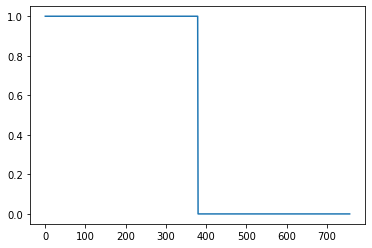

In [ ]:
 plt.plot(y)

#Training and Evaluation

(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
(210,)
Average SVM_p: 0.0


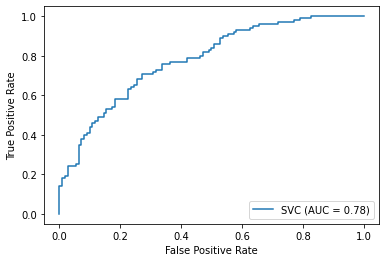

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


num = 10
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('celeba_low_1000_body.pkl', 'rb')   
    data = pickle.load(pkl_file)
    pkl_file.close()
    X_train = data["data"]
    y_train = data["label"]



    pkl_file = open('celeba_low_1000_test_body.pkl', 'rb')   
    data = pickle.load(pkl_file)
    pkl_file.close()
    X_test = data["data_test"]
    y_test = data["label_test"]

    print(y_test.shape)


    try:
               
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly', probability=True, random_state=0)
        svclassifier_p.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
  
        
    except:
        num-=1
        print(num)
    
print("Average SVM_p: "+str(SVM_p/num))


from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt 

x = plot_roc_curve(svclassifier_p, X_test, y_test)  
plt.show()

